**Preamble**: This notebook was adapted from an Introduction to Machine Learning course assignment. This notebook is intended to demonstrate a basic understanding of classification models and exploration of concepts in machine learning.

**Goal**: To develop a music genre detection machine learning model using audio files (potentially) in real-time.

**Objective**: Use the GTZAN dataset to create a classifier that can classify what music genre is playing! 🎷🎸🎹🎺 Develop a ‘baseline solution’ that uses a pre-trained classifier and fine-tuned it on the musical genre classification task using transfer learning.

**Instructions**: The entire full notebook should run in approximately 120 minutes to run on T4 GPU. The solutions for this notebook are self-contained. This notebook was intended to be executed and tested on Google Colab. Using the commands: runtime → run all.

**Dataset**: GTZAN Dataset.

Download from source: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

Placed under My Drive in the Google Drive directory and renamed as GTZAN Genre Collection.zip

Music. Experts have been trying for a long time to understand sound and what differentiates one song from another. How to visualize sound. What makes a tone different from another? This data hopefully can allow doing just that.


*   *genres original* - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
*   *images original* - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.
*   *2 CSV files* - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3-second audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

**Runtime Tips:** Select **Runtime** -> **Change Runtime Type** -> under **Hardware accelerator** click on CPU or T4 GPU.



# 1. Initializations


In [ ]:
from PIL import Image #needed to transform MFCC spectrogram into images
import random #needed to randomly display a spectrogram to visually see if they look correct
import time # to keep track of time taken to train

In [ ]:
# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For preproccessing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix


This code block will mount google drive.

*It will open a new window to get authorizations to use your Google Drive. Just follow the steps. This is a standard process*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1.2 Create path

In [ ]:
# Path for extractions
'''
zip_file_paths = ['/content/drive/My Drive/GTZAN Genre Collection.zip',
                  '/content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip']

dataset_dirs = ['/content/drive/My Drive/GTZAN Genre Collection',
                '/content/drive/My Drive/GTZAN Genre Collection Spectrograms']

'''

# assume GTZAN Genre Collection.zip has the following file structure
'''
GTZAN Genre Collection.zip
  - Data
    - genres_original
      - pop
      - rock
      - jazz
    - genres_images
'''

zip_file_path = '/content/drive/My Drive/GTZAN Genre Collection.zip'

dataset_dir = '/content/drive/My Drive/GTZAN Genre Collection'

if os.path.exists(zip_file_path):
  print(f"Extracting {zip_file_path} to {dataset_dir}")
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)
else:
  print(f"Zip file {zip_file_path} does not exist.")


Extracting /content/drive/My Drive/GTZAN Genre Collection.zip to /content/drive/My Drive/GTZAN Genre Collection


#### 1.3 Load your data and see how it looks


In [ ]:
# Get a count of the samples

# initialize an empty dictionary to store the count of samples per genre
sample_counts = {}
gtzan_dir = os.path.join(dataset_dir, 'Data/genres_original')

print(f"\nChosen dataset directory: {dataset_dir}")
classes = os.listdir(os.path.join(dataset_dir, 'Data/genres_original'))
print(f"\nNumber of classes: {len(classes)}")
print("\nClasses:")
print(classes)

# count the number of samples in each genre
total_sample_count = 0

for class_name in classes:
    class_path = os.path.join(dataset_dir, 'Data/genres_original', class_name)
    sample_count = len(os.listdir(class_path))
    total_sample_count += sample_count
    sample_counts[class_name] = sample_count

print("\nNumber of samples in each class:")
print(sample_counts)

print(f"\Total number of samples: {total_sample_count}")


Chosen dataset directory: /content/drive/My Drive/GTZAN Genre Collection

Number of classes: 10

Classes:
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Number of samples in each class:
{'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 100, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100}
\Total number of samples: 1000


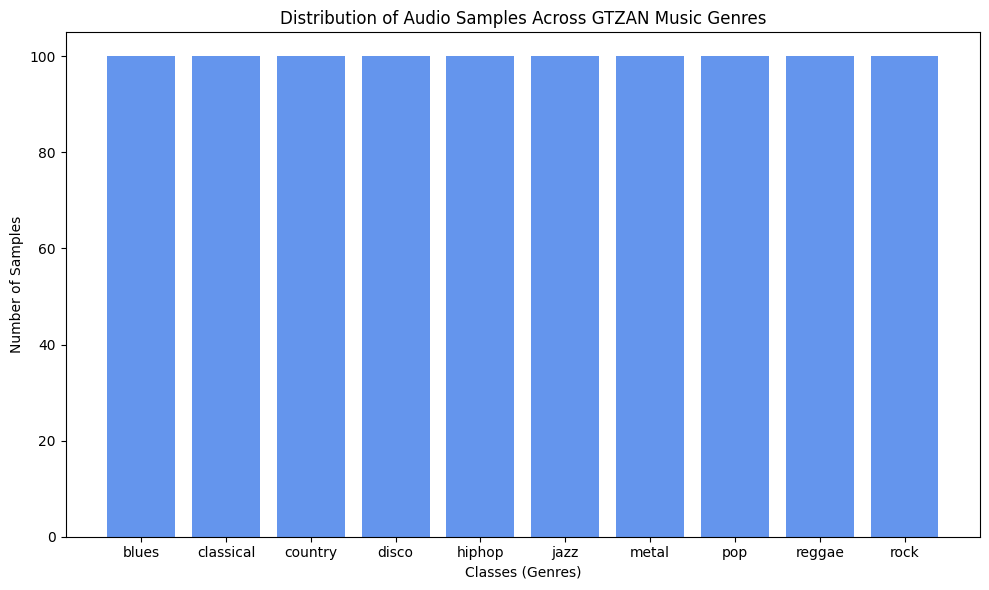

In [ ]:
# Plot the class distributions
genres = list(sample_counts.keys())
counts = list(sample_counts.values())

# create the plot
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='cornflowerblue')
plt.xlabel('Classes (Genres)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Audio Samples Across GTZAN Music Genres')
plt.tight_layout()

# show plot
plt.show()

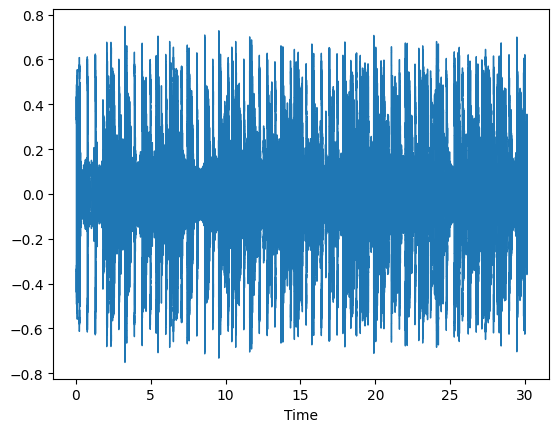

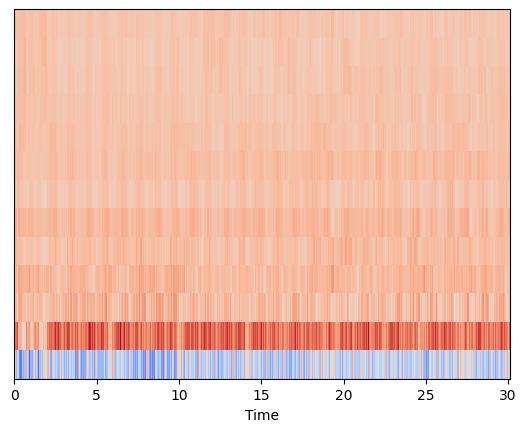

In [ ]:
# Load one audio file
y, sr = librosa.load(gtzan_dir + "/disco/disco.00000.wav")

# Show the waveform
librosa.display.waveshow(y, sr=sr)
plt.show()
plt.close()

# Generate mfcc spectrogram on the log scale
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Use 13 MFCC coefficients
librosa.display.specshow(mfcc, x_axis='time')
plt.show()
plt.close()

# 2. Preprocessing

1. Create your DataLoaders,
2. Create train and test splits.

In [ ]:
#put data into dataframe for easy access

data = []

# Iterate over the directories in gtzan_dir
for genre in os.listdir(gtzan_dir):
    genre_dir = os.path.join(gtzan_dir, genre)
    if os.path.isdir(genre_dir):
        for file_name in os.listdir(genre_dir):
            if file_name.endswith('.wav'):
                # Add the file path and genre label to the data list
                file_path = os.path.join(genre_dir, file_name)
                data.append({'file_path': file_path, 'genre': genre})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())
print(df.shape)

                                           file_path  genre
0  /content/drive/My Drive/GTZAN Genre Collection...  blues
1  /content/drive/My Drive/GTZAN Genre Collection...  blues
2  /content/drive/My Drive/GTZAN Genre Collection...  blues
3  /content/drive/My Drive/GTZAN Genre Collection...  blues
4  /content/drive/My Drive/GTZAN Genre Collection...  blues
(1000, 2)


In [ ]:
# Any additional preproccessing

# helper class
class GTZANMFCCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.loc[idx, 'file_path']
        genre = self.df.loc[idx, 'genre']

        try:
            waveform, sample_rate = librosa.load(audio_path)
            mfcc = librosa.feature.mfcc(y=waveform.squeeze(), sr=sample_rate, n_mfcc=20)  # Compute MFCC
            mfcc = torch.tensor(mfcc).unsqueeze(0)  # Convert to tensor and add channel dimension
        except Exception as e:
            print(f"Error processing file {audio_path}: {e}")
            print("DON'T PANIC - we have one corrupted file, this is normal")
            return None

        if self.transform:
            mfcc = self.transform(mfcc)

        mfcc = transforms.Resize((256, 256))(mfcc)

        # Apply one-hot encoding to the genre label
        label = torch.tensor([self.genre_to_index[genre]])
        one_hot_label = nn.functional.one_hot(label, num_classes=len(self.genre_to_index)).squeeze().float()

        return mfcc, one_hot_label


# Create a mapping from genre labels to numerical indices
genre_to_index = {genre: idx for idx, genre in enumerate(df['genre'].unique())}

# Add the genre_to_index mapping to the class
GTZANMFCCDataset.genre_to_index = genre_to_index


dataset = GTZANMFCCDataset(df)
valid_indices = [idx for idx in range(len(dataset)) if dataset[idx] is not None]

# filter out corrupted file
filtered_dataset = [dataset[idx] for idx in valid_indices]
print(len(filtered_dataset))


<ipython-input-17-c709ab9568bf>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file /content/drive/My Drive/GTZAN Genre Collection/Data/genres_original/jazz/jazz.00054.wav: 
DON'T PANIC - we have one corrupted file, this is normal
999


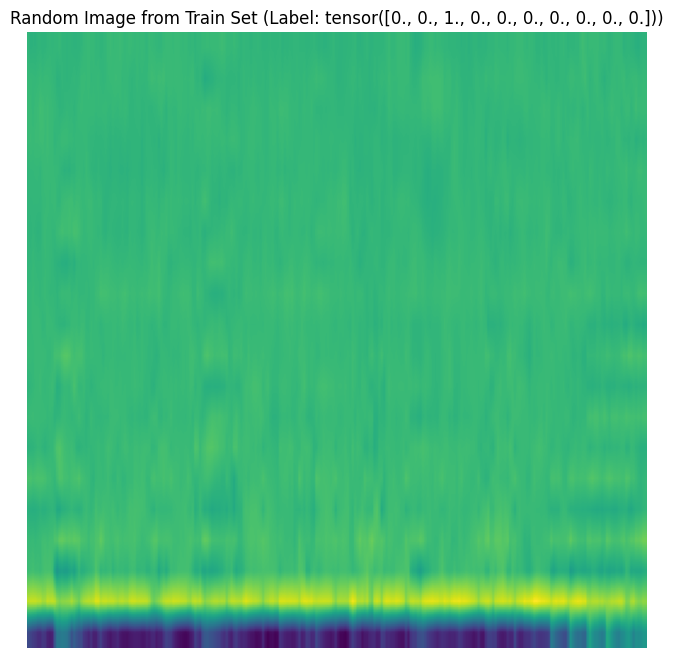

In [ ]:
# Split the dataset into train and test
# Hint: This is very similar to assignment 2

train_size = int(0.8 * len(filtered_dataset))
val_size = int(0.1 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(filtered_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# print a sample from the train set to check it converted properly
random_index = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[random_index]


plt.figure(figsize=(8, 8))
plt.imshow(image.squeeze().numpy(), aspect='auto', origin='lower')
plt.title(f"Random Image from Train Set (Label: {label})")
plt.axis('off')
plt.show()

In [ ]:
# Any additional preproccessing


# 3. Your proposed model

🎧🎸 Explain the steps taken to tune the model and how each step affected the performance.

📻🎹

We are using a CNN architecture similar to the one used in Assignment 2, with convolutional layers followed by max-pooling layers, ReLU activation functions, batch normalization, and dropout. The architecture consists of three convolutional layers with the last layer having a decreased kernel size and no padding.

As a baseline, we started with the same hyperparameters we used in Assignment 2. This included having 3 layers, 3x3 kernel, padding of 1 in each layer and the same forward function. Once we had established a baseline architecture, training on this model, we were getting roughly 42% accuracy.

In terms of hyperparamter tuning, we experimented with different hyperparameters such as learning rate, dropout rate, and the optimizer. To find the optimal values, we started with gradually increased our learning rate while monitoring the model's performance on the validation set. Similarly, we tested different dropout rates around the initial value we had of 0.1 from our baseline while also preventing overfitting. A dropout rate of 0.3 was established to be optimal as we saw an increase in performance of about 2%.

 It should be noted we also switched from using Stochastic Gradient Descent (SGD) to the Adam optimizer as it gave us a better performance 51% vs 66%. At one point, our model had stagnated with an accuracy of ~51% and upon researching further, we noticed most CNN's use Adam as their optimizer because it performs better with image classification. For example, instead of having a fixed learning rate, Adam dynamically adjusts the learning rate for each parameter by using the first and second moments of the gradients. This helps the model adapt better.   

Batch normalization layers were added after each convolutional layer to stabilize the learning process and accelerate convergence. ReLU activation function was also applied after each convolutional layer to introduce non-linearity into the model and enable the network to learn complex patterns.
Initally, batch normalization was only being applied after the first convolution layer and the activation function was being called between the two linear layers. After adding batch normalization to all the layers we increased accuracy by 3% and calling the activation function after each convolution layer. This was a necessary step because it introduces non-linearity into the neural network, which helps the network to model non linear relationships between features, making it easier for the network to learn to recognize complex patterns. This is important for our network because learning the difference between different musical genres through spectrograms is quite nuanced.

We removed padding from the third convolutional layer and applied max-pooling between each convolutional layer. Max-pooling helps in reducing the spatial dimensions of the feature maps while retaining the most important features. This helps to ensure the model is learning the subtle nuances that differenciate a specific genre from the other.

In terms of training, we trained the model for a fixed number of epochs (we chose to proceed with 15 epochs) using the Adam optimizer and CrossEntropyLoss as the loss function. Training was performed on the training dataset that was randomly split in the previous section. We settled on 15 epochs as it was a sweet spot where the model was not underfit or overfit.

Overall we were able to acheive between 68-74% accuracy on the validation and test set.

In [ ]:
# Define your model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*31*31, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.batchnorm1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.batchnorm2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.batchnorm3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Initialize the model, loss function, and optimizer

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# to account for cpu/gpu use
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Train
num_epochs = 15
start_time = time.time() # start tracking train time
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in tqdm(train_loader): #iterate through the training set
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # average loss across all batches
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

end_time = time.time() # end tracking train time
train_time = end_time - start_time # calculate train time
print(f"\nTraining time: {train_time:.2f} seconds")

100%|██████████| 25/25 [00:02<00:00, 12.35it/s]


Epoch [1/15], Loss: 1.7778


100%|██████████| 25/25 [00:00<00:00, 51.70it/s]


Epoch [2/15], Loss: 0.9569


100%|██████████| 25/25 [00:00<00:00, 51.93it/s]


Epoch [3/15], Loss: 0.5526


100%|██████████| 25/25 [00:00<00:00, 52.34it/s]


Epoch [4/15], Loss: 0.3056


100%|██████████| 25/25 [00:00<00:00, 53.05it/s]


Epoch [5/15], Loss: 0.1755


100%|██████████| 25/25 [00:00<00:00, 52.66it/s]


Epoch [6/15], Loss: 0.1128


100%|██████████| 25/25 [00:00<00:00, 52.75it/s]


Epoch [7/15], Loss: 0.0710


100%|██████████| 25/25 [00:00<00:00, 52.47it/s]


Epoch [8/15], Loss: 0.0480


100%|██████████| 25/25 [00:00<00:00, 52.70it/s]


Epoch [9/15], Loss: 0.0330


100%|██████████| 25/25 [00:00<00:00, 52.78it/s]


Epoch [10/15], Loss: 0.0242


100%|██████████| 25/25 [00:00<00:00, 53.06it/s]


Epoch [11/15], Loss: 0.0204


100%|██████████| 25/25 [00:00<00:00, 52.88it/s]


Epoch [12/15], Loss: 0.0170


100%|██████████| 25/25 [00:00<00:00, 52.71it/s]


Epoch [13/15], Loss: 0.0124


100%|██████████| 25/25 [00:00<00:00, 52.89it/s]


Epoch [14/15], Loss: 0.0109


100%|██████████| 25/25 [00:00<00:00, 52.78it/s]

Epoch [15/15], Loss: 0.0100

Training time: 8.75 seconds


In [ ]:

# Test the model using one chosen metric

#helper method to calculate accuracy
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # to account for cpu/gpu use
    if torch.cuda.is_available():
      model = model.cuda()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          _, labels_idx = torch.max(labels, 1)  # Convert one-hot labels to indices
          total += labels.size(0)
          correct += (predicted == labels_idx).sum().item()

    accuracy = correct / total #calculate accuracy
    return accuracy

val_accuracy = calculate_accuracy(model, val_loader)
print(f'Validation Accuracy: {val_accuracy*100:.4f}%')

test_accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy*100:.4f}%')

Validation Accuracy: 62.6263%
Test Accuracy: 74.2574%


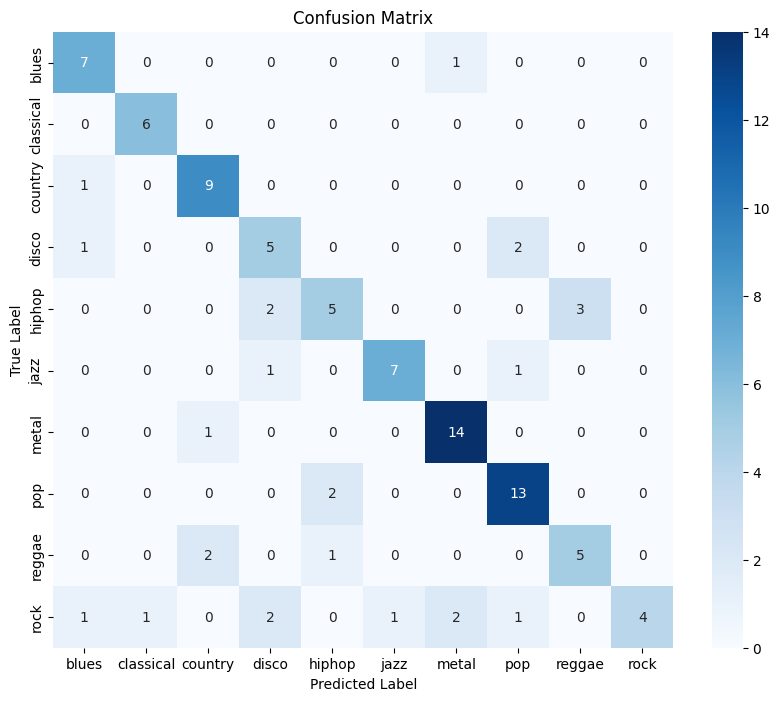

In [ ]:
# Compute and plot the confusion matrix

#helper method to plot confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    # to account for cpu/gpu use
    if torch.cuda.is_available():
      model = model.cuda()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          _, labels_idx = torch.max(labels, 1)  # Convert one-hot labels to indices
          y_true.extend(labels_idx.cpu().numpy()) #keep track of true po
          y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# Plot confusion matrix for test set
plot_confusion_matrix(model, test_loader)

# 4. Your pretrained model

The library below is a great source on how to use pretrained models:

[Pytorch pretrained models](https://pytorch.org/vision/stable/models.html)

In [ ]:
# Pretrained models and pretrained weights
#import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
# Define the pretrained model

weights = ResNet50_Weights.DEFAULT
resnet50 = resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [ ]:
# Initialize the model, loss function, and optimizer

# Modify the first layer to accept the MFCC input size
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Freeze the parameters of the pre-trained layers to prevent them from being updated during training
for param in resnet50.parameters():
    param.requires_grad = False

# Define a new final fully connected layer (fc) for the classification
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10) # 10 output classes here to denote the 10 musical genres

# All params of new fc layer to be trained
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
if torch.cuda.is_available():
  resnet50 = resnet50.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.0001)

In [ ]:
#Train
num_epochs = 15
start_time = time.time() # start tracking train time
for epoch in range(num_epochs):
  resnet50.train()
  epoch_loss = 0.0
  for i, (mfcc, labels) in enumerate(tqdm(train_loader)):
    mfcc, labels = mfcc.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = resnet50(mfcc)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

end_time = time.time() # end tracking train time
train_time = end_time - start_time
print(f'\nTraining time: {train_time:.2f} seconds')

100%|██████████| 25/25 [00:01<00:00, 23.56it/s]


Epoch [1/15], Loss: 57.0003


100%|██████████| 25/25 [00:01<00:00, 24.71it/s]


Epoch [2/15], Loss: 55.9755


100%|██████████| 25/25 [00:01<00:00, 24.52it/s]


Epoch [3/15], Loss: 55.1284


100%|██████████| 25/25 [00:01<00:00, 24.70it/s]


Epoch [4/15], Loss: 54.3432


100%|██████████| 25/25 [00:01<00:00, 24.84it/s]


Epoch [5/15], Loss: 53.3788


100%|██████████| 25/25 [00:01<00:00, 24.84it/s]


Epoch [6/15], Loss: 52.6127


100%|██████████| 25/25 [00:01<00:00, 24.94it/s]


Epoch [7/15], Loss: 52.0076


100%|██████████| 25/25 [00:01<00:00, 24.88it/s]


Epoch [8/15], Loss: 51.1386


100%|██████████| 25/25 [00:01<00:00, 24.82it/s]


Epoch [9/15], Loss: 50.4584


100%|██████████| 25/25 [00:01<00:00, 24.88it/s]


Epoch [10/15], Loss: 49.8040


100%|██████████| 25/25 [00:01<00:00, 24.85it/s]


Epoch [11/15], Loss: 49.0583


100%|██████████| 25/25 [00:01<00:00, 24.93it/s]


Epoch [12/15], Loss: 48.5245


100%|██████████| 25/25 [00:01<00:00, 24.90it/s]


Epoch [13/15], Loss: 48.0523


100%|██████████| 25/25 [00:01<00:00, 24.82it/s]


Epoch [14/15], Loss: 47.4500


100%|██████████| 25/25 [00:01<00:00, 24.78it/s]

Epoch [15/15], Loss: 46.7533

Training time: 15.25 seconds


In [ ]:
# Test the model using the same chosen metric as your own model
def calculate_resnet_accuracy(model, dataloader):
    resnet50.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
      for mfcc, labels in dataloader:
        mfcc, labels = mfcc.to(device), labels.to(device)
        outputs = resnet50(mfcc)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        _, labels= torch.max(labels, 1)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

val_accuracy = calculate_resnet_accuracy(resnet50, val_loader)
print(f'Validation Accuracy: {val_accuracy*100:.4f}%')

test_accuracy = calculate_resnet_accuracy(resnet50, test_loader)
print(f'Test Accuracy: {test_accuracy*100:.4f}%')

Validation Accuracy: 47.4747%
Test Accuracy: 51.4851%


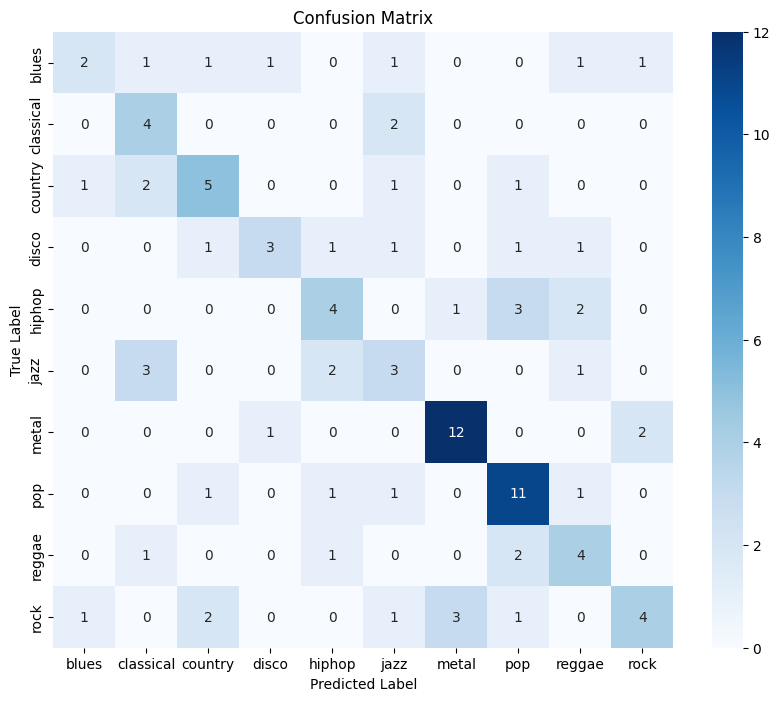

In [ ]:
# Compute and plot the confusion matrix

# Plot confusion matrix for test set
plot_confusion_matrix(resnet50, test_loader)

# Comparisons

🎧🎸 Compare the proposed model and the pretrained model in terms of performance. Is the model doing a better/worse job than the pretrained model? Why? Describing confusion matrices is neccessary to answer this question. Include other metrics, such as accuracy, train-time, etc.

📻🎹

The main metric we used to compare the proposed model and the pretrained model in terms of performance is accuracy. We have a balanced dataset and proposed accuracy to be a satisfactory performance metric as it describes how the model performs across all classes (hence useful when all classes are of equal importance). It is calculated as the ratio between the number of correct predictions to the total number of predictions.

To compare both models we first trained both our custom model and the pretrained model on the same split training set. Both models were then also evaluated on the same splitted test set to compare their accuracies and ensure they were tested in the same conditions.

**Results**<br>
**Our custom CNN model achieved the following accuracies:**<br>
Validation Accuracy: 69.6263%<br>
Test Accuracy: 74.2574%<br>
Training time: 8.75 secs

**The pretrained ResNet50 achieved the following accuracies:**<br>
Validation Accuracy: 47.4747%<br>
Test Accuracy: 51.4851%<br>
Training time: 15.25 secs

Off the accuracy and training alone, we can see that our custom model had a better accuracy and took a shorter amount to train (almost half the time it took ResNet50).

We can also visualize the performance using the confusion matrices. The diagonal elements from top left to bottom right represent the correctly classified instances. The higher the value of the diagonal, the better the model's performance. The off-diagonal elements represent missclassifications. Each of these elements indicates the number of instances from one class that were classified as another class.

**Custom CNN Confusion Matrix Analysis:**<br>
The confusion matrix shows that our model performs decently across all genres with higher accuracy. There is a stronger diagonal, which reflects higher accuracy in predictions for most classes. Some confusion exists between disco, hiphop, and pop, shown by the off-diagonal elements. The diagonal elements represent the correct classifications and the diagonal line in the produced confusion matrix for our model is opaque indiciating few misclassifications.

**ResNet50 Confusion Matrix Analysis:**<br>
On the other hand, the confusion matrix for ResNet50 shows that our model struggles with classifying several genres, especially classical, hiphop, metal, pop, and reggae, as evident from the large amount of off-diagonal elements. The diagonal line of the confusion matrix is not consistently opaque (less pronounced) indiciating lower accuracy (hence higher frequency of misclassifications across various classes).

Overall, the custom CNN's confusion matrix shows a more consistent and accurate classification performance. We see that the diagonal line is much more vibrant and consistently opaque in our custom model's confusion matrix meaning higher number of true positives and fewer false positives.

It is evident that our model performed better than the pretrained model in terms of accuracy and there are several factors that play into why they performed differently. Although our model and the ResNet50 model are both CNNs, our custom CNN is better suited for this musical classification task. This is because we made tweaks to it in step 3 of this notebook in order to perform decently. The ResNet50 architecture is more generic as it was pretrained on a large dataset (ImageNet) for a different task and not specifically this. It's important to note that when applying the concept of transfer learning, we froze the parameters of the pre-trained layers, preventing them from being updated from training. This was to retain the learned representations from the pretraining task but it also limits the ability of the model to adapt to the complexities of our specific music genre classification task. Although we did define a new final fully connected layer (fc) for the classification, the ResNet50 model may not have fully captured the specific features necessary for accurate music genre classification. Thus, our custom CNN could have learned more specific and relevant features for this specific music genre classification task which lead to a better performance.



🎧🎸 What will you do differently? Why?
> In terms of the dataset, preproccessing, modeling, etc.

📻🎹

In terms of the dataset, one of our samples was corrupted and only had 1000 items. Although, our dataset was generally balanced, there wasn't much variety within each genre. For example, the samples in pop were quite similar but generally they encompass a wide range of musical styles. Additionally, this dataset doesn't include lyrics in any of their samples which means it might not be able to correctly classify a regular song with lyrics off spotify. Not to mention, the dataset only contains 1000 samples which is quite small compared to how many songs there are worldwide. Using a larger dataset could help our model generalize better. Next time I would try to use a larger dataset like GTZAN+ which is an extended version of the dataset we used or FMA which includes more sample variety within genres. This will help our model learn more meaningful features and be trained on samples that are representative of the music landscape today so it can generalize better.

<br>


In terms of preprocessing, currently we extract the MFCC features from the raw audio signal and convert it into spectrograms that are fed into a CNN with three convolutional layers. Next time, we could try leveraging the features.csv file which already contains the features of the audio files. This would simplify our preprocessing by ensuring the features we're extracting are relevant and consistent with what other users have used. This can help standardize our preprocessing and we can better fine tune our model on previous experiments to acheive better/similar results.

<br>

In terms of the modeling, we chose to use a CNN because we were using spectrograms and CNN's are known for classifying images. To further improve our model, we could try adding more layers from three to five. This might help the model learn more features to help it better classify genres. Alternatively, upon doing further research, we read a few papers stating that KNN's could be used for this classification task since music within a genre tends to be similar. From the research we conducted,implementing an KNN model tends to be a popular alternative for this solution and could potentially acheive a higher accuracy than our current model which sits at ~72% accuracy.











All done! 🎶💃🕺